In [1]:
import time

import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from concrete.ml.sklearn import LinearRegression as ConcreteLinearRegression

In [6]:
!pip install matplotlib
import matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 12.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 10.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.1 MB/s eta 0:00:00


In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

train_plot_config = {"c": "black", "marker": "D", "s": 15, "label": "Train data"}
test_plot_config = {"c": "red", "marker": "x", "s": 15, "label": "Test data"}


def get_sklearn_plot_config(r2_score=None):
    label = "Scikit-Learn"
    if r2_score is not None:
        label += f", R²={r2_score:.4f}"
    return {"c": "blue", "linewidth": 2.5, "label": label}



def get_concrete_plot_config(r2_score=None):
    label = "Concrete ML"
    if r2_score is not None:
        label += f", R²={r2_score:.4f}"
    return {"c": "orange", "linewidth": 2.5, "label": label}


In [10]:
# pylint: disable=unbalanced-tuple-unpacking
X, y = make_regression(
    n_samples=200, n_features=1, n_targets=1, bias=5.0, noise=30.0, random_state=42
)
# pylint: enable=unbalanced-tuple-unpacking

# We split the data-set into a training and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# We sort the test set for a better visualization
sorted_indexes = np.argsort(np.squeeze(X_test))
X_test = X_test[sorted_indexes, :]
y_test = y_test[sorted_indexes]

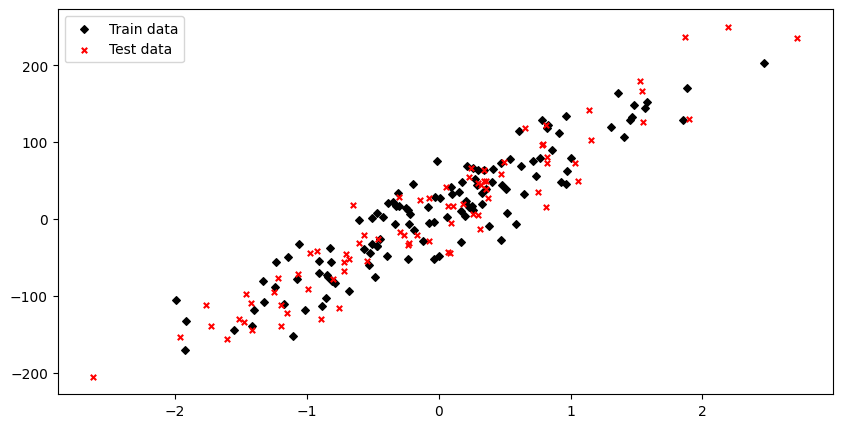

In [11]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.legend()
display(fig)

In [12]:
sklearn_lr = SklearnLinearRegression()
sklearn_lr.fit(X_train, y_train)
y_pred = sklearn_lr.predict(X_test)

# Compute the R2 scores
sklearn_r2_score = r2_score(y_test, y_pred)

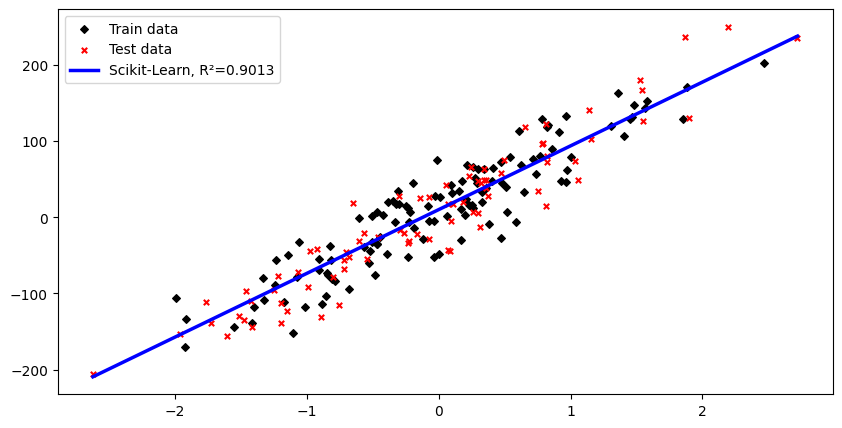

In [13]:

plt.ioff()
plt.clf()

fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.plot(X_test, y_pred, **get_sklearn_plot_config(sklearn_r2_score))
ax.legend()
display(fig)

In [14]:
# We quantize the inputs using 8-bits
concrete_lr = ConcreteLinearRegression(n_bits=8)

# We train the concrete linear regression model on clear data
concrete_lr.fit(X_train, y_train)

# We densify the space representation of the original X,
# to better visualize the resulting step function in the following figure
x_space = np.linspace(X_test.min(), X_test.max(), num=300)
x_space = x_space[:, np.newaxis]
y_pred_q_space = concrete_lr.predict(x_space)

# Now, we can test our Concrete ML model on the clear test data
y_pred_q = concrete_lr.predict(X_test)

# Compute the R2 scores
quantized_r2_score = r2_score(y_test, y_pred_q)

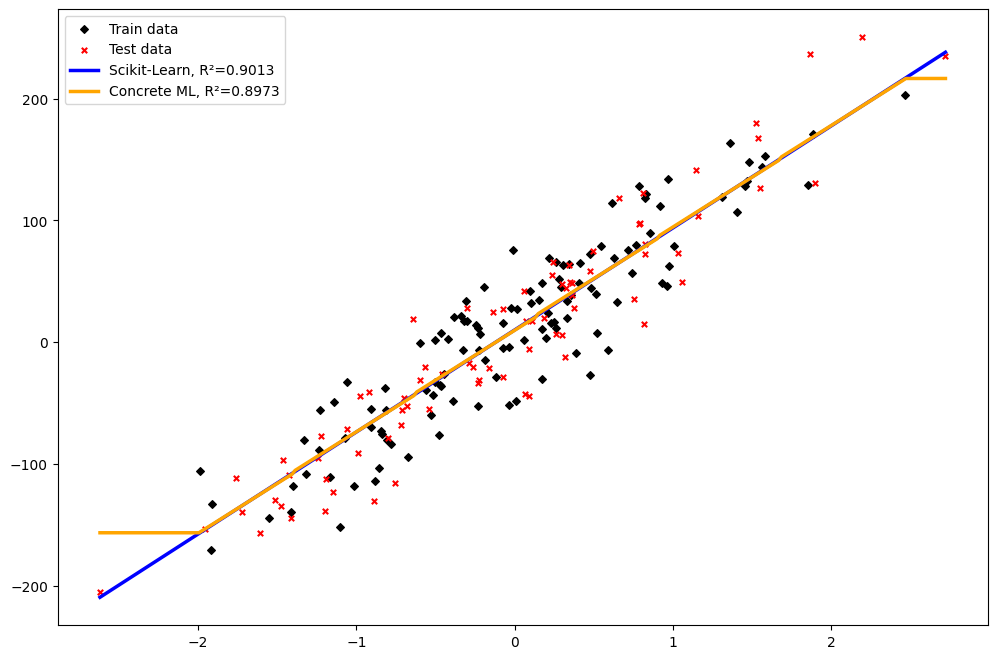

In [15]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.plot(X_test, y_pred, **get_sklearn_plot_config(sklearn_r2_score))
ax.plot(x_space, y_pred_q_space, **get_concrete_plot_config(quantized_r2_score))
ax.legend()
display(fig)

In [16]:
fhe_circuit = concrete_lr.compile(X_train)

In [17]:

print(f"Generating a key for a {fhe_circuit.graph.maximum_integer_bit_width()}-bit circuit")

Generating a key for a 9-bit circuit


In [18]:

time_begin = time.time()
fhe_circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.4f} seconds")

Key generation time: 0.0128 seconds


In [19]:

time_begin = time.time()
y_pred_fhe = concrete_lr.predict(X_test, fhe="execute")
print(f"Execution time: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

Execution time: 0.0226 seconds per sample


In [20]:
# Measure the FHE R2 score
fhe_r2_score = r2_score(y_test, y_pred_fhe)

print("R^2 scores:")
print(f"scikit-learn (clear): {sklearn_r2_score:.4f}")
print(f"Concrete ML (quantized): {quantized_r2_score:.4f}")
print(f"Concrete ML (FHE): {fhe_r2_score:.4f}")

# Measure the error of the FHE quantized model with respect to the clear scikit-learn float model
concrete_score_difference = abs(fhe_r2_score - quantized_r2_score) * 100 / quantized_r2_score
print(
    "\nRelative score difference for Concrete ML (quantized clear) vs. Concrete ML (FHE):",
    f"{concrete_score_difference:.2f}%",
)

# Measure the error of the FHE quantized model with respect to the clear float model
score_difference = abs(fhe_r2_score - sklearn_r2_score) * 100 / sklearn_r2_score
print(
    "Relative score difference for scikit-learn (clear) vs. Concrete ML (FHE) scores:",
    f"{score_difference:.2f}%",
)
     

R^2 scores:
scikit-learn (clear): 0.9013
Concrete ML (quantized): 0.8973
Concrete ML (FHE): 0.8973

Relative score difference for Concrete ML (quantized clear) vs. Concrete ML (FHE): 0.00%
Relative score difference for scikit-learn (clear) vs. Concrete ML (FHE) scores: 0.45%


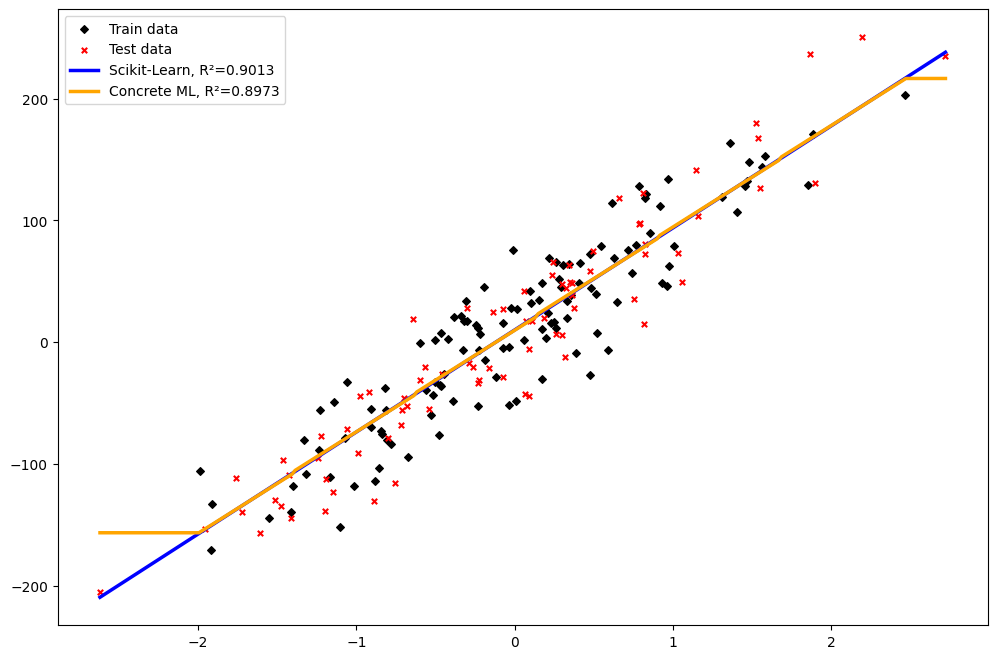

In [21]:
# For better visualization
y_pred_q_space = concrete_lr.predict(x_space)
     

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(X_train, y_train, **train_plot_config)
ax.scatter(X_test, y_test, **test_plot_config)
ax.plot(X_test, y_pred, **get_sklearn_plot_config(sklearn_r2_score))
ax.plot(x_space, y_pred_q_space, **get_concrete_plot_config(fhe_r2_score))
ax.legend()

display(fig)
     